In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("cardio_train.csv", sep=';')
%matplotlib inline     
sns.set(color_codes=True)

### Cleaning the data

In [198]:
# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]
# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

In [199]:
# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

### Making the hypertention group

In [200]:
# bin blood pressure groups based on the api hi/ lo variables
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp1'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


### Making the BMI group

In [201]:
# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2

# create BMI group categorical bins
df['bmiGrp'] = np.where((df.bmi < 18.5), 1, 0)
df['bmiGrp'] = np.where((df.bmi >= 18.5) & (df.bmi < 25), 2, df.bmiGrp)
df['bmiGrp'] = np.where((df.bmi >= 25) & (df.bmi < 30), 3, df.bmiGrp)
df['bmiGrp'] = np.where((df.bmi >= 30), 4, df.bmiGrp)
df['bmiGrp1'] = pd.cut(df.bmiGrp,[0,1,2,3,4],4,labels=['Under Weight','Normal Weight','Over Weight','Obese' ]) # this creates a new variable


In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53053 entries, 1 to 69999
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           53053 non-null  int64   
 1   age          53053 non-null  int64   
 2   gender       53053 non-null  int64   
 3   height       53053 non-null  int64   
 4   weight       53053 non-null  float64 
 5   ap_hi        53053 non-null  int64   
 6   ap_lo        53053 non-null  int64   
 7   cholesterol  53053 non-null  int64   
 8   gluc         53053 non-null  int64   
 9   smoke        53053 non-null  int64   
 10  alco         53053 non-null  int64   
 11  active       53053 non-null  int64   
 12  cardio       53053 non-null  int64   
 13  bp           53053 non-null  int64   
 14  bp1          53053 non-null  category
 15  bmi          53053 non-null  float64 
 16  bmiGrp       53053 non-null  int64   
 17  bmiGrp1      53053 non-null  category
dtypes: category(2), float64(2)

In [203]:
# 5. Rearrange the columns that are important for the analysis as per domein knowledge and EDA
df_f = df[['cholesterol','gluc','bp','gender','bmi','age', 'cardio']]

df_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53053 entries, 1 to 69999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cholesterol  53053 non-null  int64  
 1   gluc         53053 non-null  int64  
 2   bp           53053 non-null  int64  
 3   gender       53053 non-null  int64  
 4   bmi          53053 non-null  float64
 5   age          53053 non-null  int64  
 6   cardio       53053 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 3.2 MB


### Training and testing split

In [204]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'cardio' in df_f:
    y = df_f['cardio'].values # get the labels we want
    del df_f['cardio'] # get rid of the class label
    X = df_f.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [205]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.5837338610875507
confusion matrix
 [[1074 3637]
 [ 780 5120]]
====Iteration 1  ====
accuracy 0.6188860616341533
confusion matrix
 [[1861 2766]
 [1278 4706]]
====Iteration 2  ====
accuracy 0.6192630289322402
confusion matrix
 [[1958 2679]
 [1361 4613]]


### Interpretation of the weight

In [206]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_f.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

cholesterol has weight of 0.4696552228933826
gluc has weight of -0.048902603600564344
bp has weight of 0.6935223593974641
gender has weight of -0.2856955132450691
bmi has weight of -0.024779535159248155
age has weight of -6.74712148756417e-05


### Normalize weight

In [207]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_f.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.7112430496654415
[[3216 1421]
 [1643 4331]]
gluc has weight of -0.07321254330792962
gender has weight of -0.0069276389829644475
bmi has weight of 0.14996277880849143
age has weight of 0.32227920639349994
cholesterol has weight of 0.3445143155021695
bp has weight of 0.7618269985254803


### Graph the weight

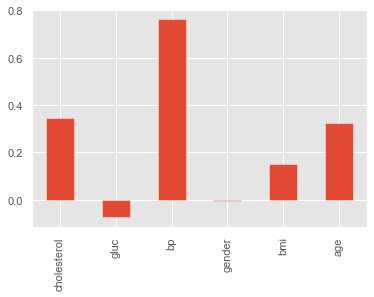

In [208]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df_f.columns)
weights.plot(kind='bar')
plt.show()

### This two chunk of code using the pipeline

In [209]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)
print(weights)

[[ 0.33908441 -0.07522949  0.75920285 -0.00890553  0.15025197  0.32128141]
 [ 0.35308172 -0.07843223  0.76585208 -0.00857407  0.154322    0.31487643]
 [ 0.33524707 -0.06686452  0.75962849 -0.01201445  0.15413654  0.31756465]]


In [210]:
import plotly.offline as py
from plotly.offline import iplot
py.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go


error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': df_f.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

### Analysis of colinearity

In [211]:
# need to be done here

###  Support Vector Machine

In [212]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7122797097351805
[[3329 1308]
 [1745 4229]]


In [213]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(26350, 6)
(26350,)
[12427 13923]


[[ 7.06999816e-01 -2.01684694e-05  1.18142949e+00 -2.26528528e-05
   6.24866552e-05  7.74607352e-05]]


<AxesSubplot:>

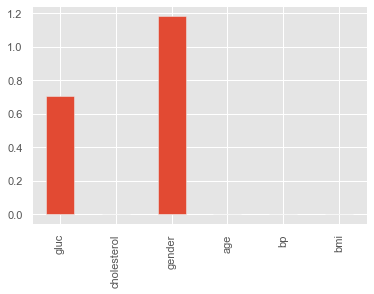

In [214]:
df_fk= df_f[['gluc', 'cholesterol', 'gender', 'age', 'bp','bmi']]
# train the model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df_fk.columns)
weights.plot(kind='bar')

### Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors 

In [215]:
# train the model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object
# make a dataframe of the training data
df_tested_on = df_f.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()
df_support['cardio'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df_f['cardio'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28354 entries, 15784 to 17217
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cholesterol  28354 non-null  int64  
 1   gluc         28354 non-null  int64  
 2   bp           28354 non-null  int64  
 3   gender       28354 non-null  int64  
 4   bmi          28354 non-null  float64
 5   age          28354 non-null  int64  
 6   cardio       28354 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 1.7 MB


/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Let make a graphic of the original data and instances use as vector support

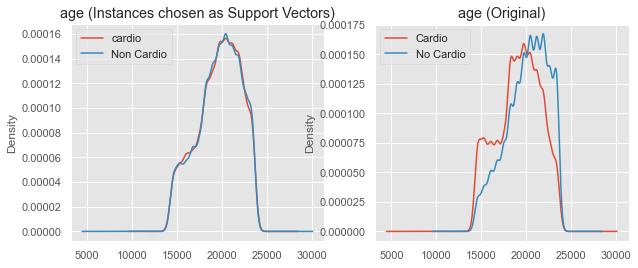

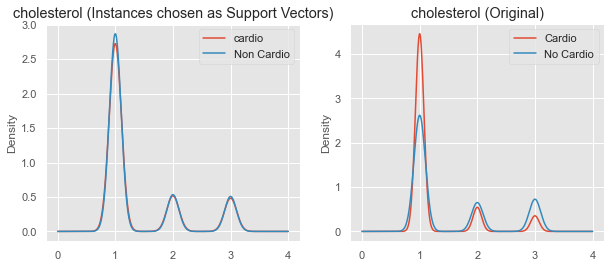

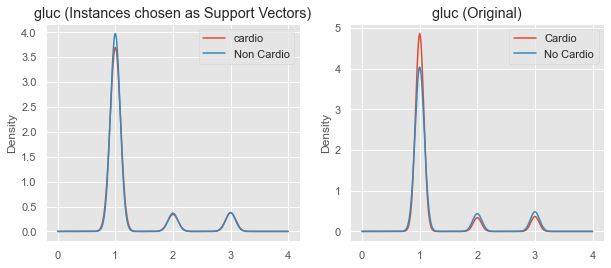

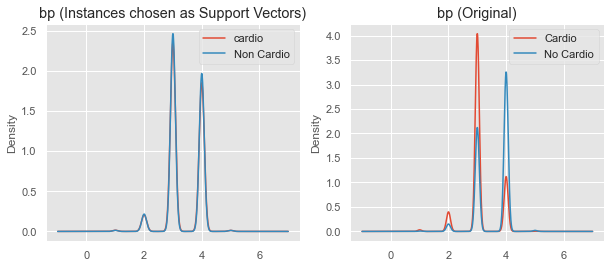

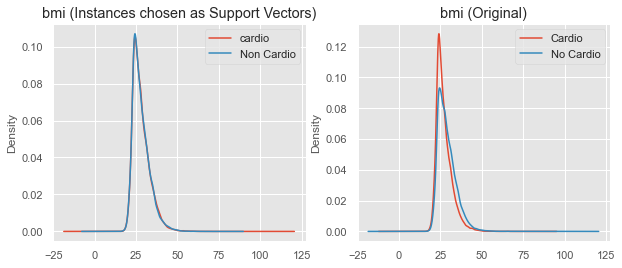

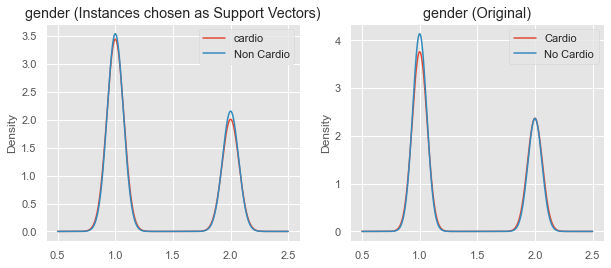

In [216]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['cardio'])
df_grouped = df_f.groupby(['cardio'])

# plot KDE of Different variables
vars_to_plot = ['age','cholesterol','gluc','bp', 'bmi', 'gender']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['cardio','Non Cardio'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Cardio','No Cardio'])
    plt.title(v+' (Original)')



###  Use some compact notation for creating a linear SVM classifier with stichastic descent

In [217]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit( n_splits=1,test_size=0.5)

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM:', acc)

SVM: 0.7055075960342293


### Use some compact notation for creating a logistic regression classifier with stochastic descent

In [218]:
log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.7111245146454556


### Now lets use some of what we know from this class to reduce the dimensionality of the set

In [219]:
%%time
# now lets use some of what we know from this class to reduce the dimensionality of the set
from sklearn.decomposition import PCA
n_components = 6
pca = PCA(n_components=n_components, svd_solver='randomized')
iterations = 500
log_sgd = SGDClassifier(
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', max_iter=iterations, n_jobs=-1, penalty='l2')
# you could also set this up in a pipeline
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(pca.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(pca.transform(X[test_idx]))
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)
print('Logistic Regression:', acc)



Logistic Regression: 0.6433822143476458
CPU times: user 1.34 s, sys: 128 ms, total: 1.47 s
Wall time: 756 ms


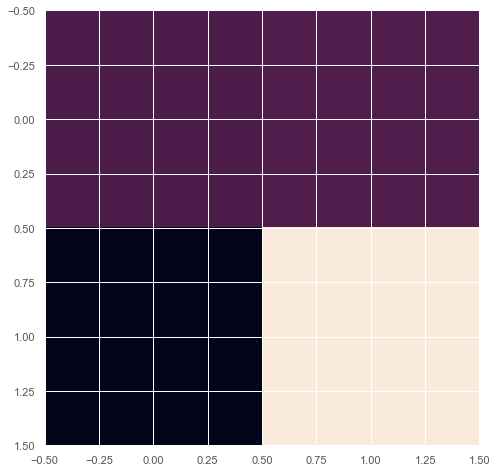

In [174]:
f = plt.figure(figsize=(8,8))
plt.imshow(conf)